In [2]:
import pandas as pd 
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
med_charges = pd.read_csv("insurance2.csv")

In [4]:
med_charges.charges.size

1338

**Quick peak at "Charges" variable from a statistical persepctive**
Before we sample from "charges" for our two individual and indepedent samples, lets quickly take a holistic look with a statistical persepctive.

95% CI for Charges
Lower limit: 12635.331
Upper limit: 13909.342


Sampling Distribution of means (via bootstrapping, B=10,000)
mean charge: 13266.517
t: -1.96
lower limit of 95% CI for "charges": 12624.475




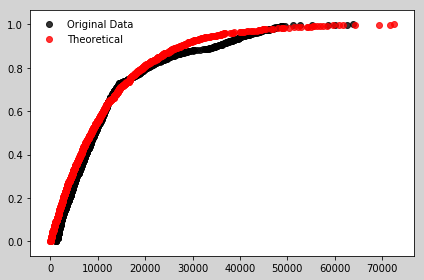

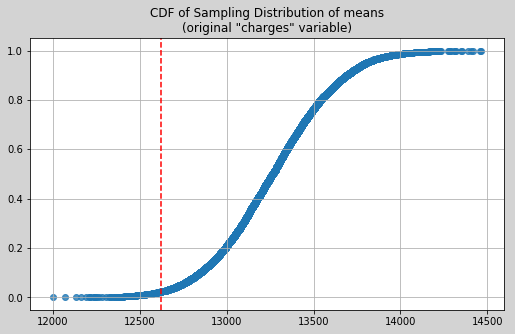

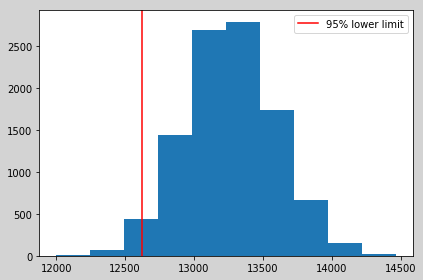

In [9]:
np.random.seed(0)
# single sample (n=500)
sample = np.random.choice(med_charges.charges, 500)
#sampling distribution of means
sampdistmeans= [np.mean(np.random.choice(med_charges.charges, len(med_charges.charges))) for _ in range(10000)]
# 95% CI for "charges" variable
lower, upper = np.percentile(sampdistmeans, 2.5), np.percentile(sampdistmeans, 97.5)
print('95% CI for Charges\nLower limit: {}\nUpper limit: {}\n\n'.format(round(lower,3), round(upper,3)))

# Function for computing ECDF
np.random.seed(1)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of observations(n) (needs to be a 1d array)
    n = len(data)
    # x-data
    x = np.sort(data)
    # y-data
    y = np.arange(1, n+1) / n
    return x, y

# Compute and plot ECDF from original data
plt.subplots(facecolor='lightgrey')
x, y = ecdf(med_charges.charges)
sns.regplot(x, y, color='black', label='Emperical', fit_reg=False)

# plot ecdf next to theoretical
# np.random.exponential == ss.expon.rvs() 
gen_charge_data = np.random.exponential(scale=np.std(med_charges.charges),
                                        size=len(med_charges.charges))    
x, y = ecdf(gen_charge_data)
sns.regplot(x, y, color='r', label='Theoretical', fit_reg=False)
plt.title('Theoretical vs Emperical: "Charges"')
plt.ylabel('Fraction (%)')
plt.xlabel('hospital charges')
plt.legend(frameon=False); plt.tight_layout()

alpha = 0.025#0.05/2
t_, se_bootstrap = round(ss.t.ppf(1-alpha, 10000),3), np.std(sampdistmeans, ddof=1)

# Margin of Error(MOE) of sampling distributions of means for "charges" variable:
#MOE = critical value * SE
lowlim_charges = round(np.mean(sampdistmeans) - (t_*se_bootstrap),3)
print('Sampling Distribution of means (via bootstrapping, \
B=10,000)\nmean charge: %.3f' %np.mean(sampdistmeans))
print('t: -{}\nlower limit of 95% CI for "charges": {}\n\n'.format(t_, lowlim_charges))

# Plot ECDF of Sampling Distribution
fig, ax = plt.subplots(1,1, facecolor='lightgrey', figsize=(8.5, 5))
x_bs, y_bs = ecdf(sampdistmeans)

sns.regplot(x=x_bs, y=y_bs, fit_reg=False)
plt.axvline(lowlim_charges, c='r', ls='--')
plt.title('CDF of Sampling Distribution of means\n(original "charges" variable)')
plt.grid()
plt.show()

#Plot Sampling Distribution of means
plt.figure(facecolor='lightgrey')
plt.hist(sampdistmeans)
plt.axvline(lowlim_charges, c='r', 
            label= '95% lower limit')
plt.legend()
plt.tight_layout()

Above, we performed a few operations on our variable, "charges", representing all of the charges from a single hospital. 

    - For further intuition, a note: As apposed all charges from every hospital, or in theory the entire population of hopsital charge data, we are from the get-go, working with a sample that will for the context of this tutorial represent our population and our individual independent samples established below, technically samples of a sample, represent simply our independant samples that we will perform statistical testing on. Rarely if ever do we have all-the-data, or the entire population.
    
Lets now establish our two independant samples mentioned above for hospital insurance-claim charges and charges without claims. 

In [58]:
np.random.seed(1)
# Observed independant samples
noclaimsample = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
claimsample = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']

# Analysis of Variance Tests and assumptions about Homogeneity

There are **two ways of performing a t-test**, depending on certain assumptions. Before running t-tests for mean comparisons on groups or samples, it is usual to analyze the variances of the groups first, and to test whether the samples have equal variance or **homogeneity** of variance or if they are unequal.

## F-test
- Equality of variance test. This test, tests for the null hypothesis of equal variance between groups for two normal distributed groups. This test though is highly dependent upon the assumption of our groups being from a normal distribution.

**Null and Alternative for F-test**

* $H_{o}$: $s_1^{2}$ == $s_2^{2}$ (_Equal variance or homogeneity of variance for claims charges and no-claims charges_)

* $H_{a}$: $s_1^{2}$ != $s_2^{2}$ (_Unequal variance between claims charges and no-claims charges_)

In [67]:
from scipy.stats import f

#calculate f-statistic, this is representative of how far away the difference between group means is from F-dist mean of zero 
f_stat = np.var(noclaimsample) / np.var(claimsample)

#Degrees of freedom for each group
dof_noclaims, dof_claims = len(noclaimsample) - 1, len(claimsample) - 1

# Generate p-value representing our probability for the our f-statistic testing whether p > a
a = 0.05
p_val = ss.f.sf(f_stat, dof_noclaims, dof_claims)
p_val_test = ss.f.cdf(f_stat, dof_noclaims, dof_claims)
print(p_val, p_val_test)

if p_val < a:
    print('Results: P-value: {} < Alpha {}\nOutcome: Fail to Reject Null Hypothesis'.format(p_val, a))
else:
    print('Results: P-value {} > Alpha {}\nOutcome: Reject Null Hypothesis'.format(p_val, a))

0.9999999999999999 1.0715317860855111e-74
Results: P-value 0.9999999999999999 > Alpha 0.05
Outcome: Reject Null Hypothesis


## The Bartlett test

> "Bartlett's test ( Snedecor and Cochran, 1983) is used to test if k samples have equal variances. Equal variances across samples is called homogeneity of variances. Some statistical tests, for example the analysis of variance, assume that variances are equal across groups or samples. The Bartlett test can be used to verify that assumption." - [itl.nist.gov](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm)



## The Levene Test

> "In statistics, Levene's test is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups. Some common statistical procedures assume that variances of the populations from which different samples are drawn are equal." - [Wikipedia](https://en.wikipedia.org/wiki/Levene%27s_test)

## F-OneWay ANOVA

Statistical test assumptions are that the mean for 2 or more groups are equal (Null). If test outcome is suggestive otherwise (alternative) we reject null and conclude the data samples have a different distributions.

- Fail to Reject H0: All sample distributions are equal.
- Reject H0: One or more sample distributions are not equal.

> "The purpose of a one-way analysis of variance (one-way ANOVA) is to compare the
means of two or more groups (the independent variable) on one dependent variable
to see if the group means are signifcantly different from each other." - Statistics in Plain English, 2010

In [47]:
from scipy.stats import f_oneway
# compare samples
F_statistic, p = f_oneway(noclaimsample, claimsample)
print('F-statistic: %.3f, P-value: %.3f' %(F_statistic, p))
# interpret
alpha = 0.05
if p > alpha:
    print('NO difference in distributions across samples; Accept null (fail to reject) H0')
else:
    print('Difference in distributions across samples; Reject null (Ha)')

F-statistic: 141.451, P-value: 0.000
Difference in distributions across samples; Reject null (Ha)


... Another interpretation of f-OneWay ANOVA test would be that there is a significant effect on our hospital charges, we just are unsure of where its coming from. Next we will perform ANOVA again using a regression formula, because essentially that is what ANOVA is, a generalized linear model. The Syntax for the Linear Regression model or Ordinary Least Squares in Statsmodels is:
    
    - model_name = ols('outcome_variable ~ group1 + group2 + groupN', data=your_data).fit()

In [ ]:
from statsmodels.regression.linear_model import OLS

# subset independent variable into its groups, in this case, categories: 1 = claim, 0 = no-claim
# Observed independant samples
#noclaims = med_charges.loc[(med_charges.insuranceclaim == 0), 'insuranceclaim']
#claims = med_charges.loc[(med_charges.insuranceclaim == 1), 'insuranceclaim']
#ols_data1 = ols_data.assign(claims='yes', noclaims='no')
#ols_data = pd.DataFrame.from_dict({'claims':claims,'noclaims':noclaims,'charges':med_charges.charges})

#noclaims_categoric = med_charges.loc[med_charges.insuranceclaim == 0, 'charges'] #= 0
#claims_categoric = med_charges.loc[med_charges.insuranceclaim == 1, 'charges'] #= 1
# claims_categoric
#med_charges.insurance_claim_categoric = pd.concat(noclaims_categoric, claims_categoric)
#med_charges.insurance_claim_categoric

#results = OLS('charges ~ claims + noclaims', ols_data).fit()
#ols_model = ols('PRICE ~ CRIM + RM + PTRATIO', bos).fit()

*****************************
# Hypothesis Testing (Traditional frequentist methods)

**State Null and Alternate Hypothesis**

- null, $H_{o}$: $mean_{1}$ == $mean_{2}$ (average charge w/ claims = average charge w/o claims, a ZERO dollar difference is assumed.)

- Alternate, $H_{a}$:  $mean_{1}$ != $mean_{2}$ (average charge w/ claims != average charge w/o claims, a difference > ZERO is our alternate.)

We assume a two-tailed distribution, where the rejection of the null hypothesis could be interpreted as the first mean is either smaller or larger than the second mean. Below we will run our independant samples t-test for our two groups, charges w/ claims and w/o claims, using traditional frequentist methods.

## Critical Value for hypothesis testing

The t statistic calculated by the test can be interpreted by comparing it to critical values from the t-distribution. The critical value can be calculated using the degrees of freedom and a significance level with the percent point function (PPF).

- Calculate critical value w/ percent point function (PPF) given significance level(alpha) i.e., a = 0.05 (95% confidence).

We can interpret the statistic value in a two-tailed test, meaning that if we reject the null hypothesis, it could be because the first mean is smaller or greater than the second mean. To do this, we can calculate the absolute value of the test statistic and compare it to the positive (right tailed) critical value, as follows:

**If abs(t-statistic) <= critical value: Fail to reject null (accept null hypothesis), No difference between means.**

**If abs(t-statistic) > critical value: Reject the null, there is a difference between means of two groups or that the means aren't equal.**

**User-Defined t-test**

In [60]:
from scipy.stats import t

# Calculate t-test for two independent groups or samples manually
def independent_ttest(group1, group2, alpha):
    # calculate means
    mean1, mean2 = np.mean(group1), np.mean(group2)
    # calculate sample standard deviations
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    # calculate standard errors
    n1, n2 = len(group1), len(group2)
    se1, se2 = std1/np.sqrt(n1), std2/np.sqrt(n2)
    # Alternatively, can use np.sem() function for SE's
    #se1, se2 = np.sem(group1), np.sem(group2)
    # standard error on the difference between the samples
    se_diff = np.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    tstat = (mean1 - mean2) / se_diff
    # degrees of freedom
    dof = n1 + n2 - 2
    # calculate the critical value
    alpha = 0.05
    crit_val = ss.t.ppf(1.0 - alpha, dof)
    # calculate the p-value
    p = (1 - ss.t.cdf(np.abs(tstat), dof)) * 2
    return tstat, dof, crit_val, p

In [65]:
# Hypothesis test: Independant t-test
alpha = 0.05
t, df, critval, pval = independent_ttest(noclaimsample, claimsample, alpha)
print('t-statistic: %.3f\ndof: %.3f\ncritical value: %.3f\np-value: %.3f\n' %(t, df, critval, pval))

# Evaluate test w/ critical value
if np.abs(t) <= critval:
    print('~Hypothesis test w/ critical value\n  Fail to reject null, No difference between means.\n')
else:
    print('~Hypothesis test w/ critical value\n  Reject null; Difference between means.\n')

t-statistic: -13.298
dof: 1336.000
critical value: 1.646
p-value: 0.000

~Hypothesis test w/ critical value
  Reject null; Difference between means.



## P-value for hypothesis testing

We can also retrieve the cumulative probability of observing the absolute value of the t-statistic using the cumulative distribution function (CDF) of the t-distribution in order to calculate a p-value.

- Calculate p-value w/ CDF on the t-distribution. Our p is the probability of drawing a result as >= the result obtained when the null hypothesis is true. In our case >= 0 (Zero dollars).

The p-value can then be compared to a chosen significance level (alpha) i.e., alpha(a)=0.05 to determine if the null hypothesis can be rejected:

- Our significance level (alpha, "a") = 0.05. Is the probability of rejecting the null hypothesis when the null hypothesis is true, or the risk probability of making a wrong decision.

**If p > alpha: Fail to reject null (Accept null hypothesis), No difference between means or equal means of two groups.**

**If p <= alpha: Reject null hypothesis, this means there is a difference between mean values of the two groups.**

In [66]:
# Hypothesis test: Independant t-test
alpha = 0.05
t, df, critval, pval = independent_ttest(noclaimsample, claimsample, alpha)
print('t-statistic: %.3f\ndof: %.3f\ncritical value: %.3f\np-value: %.3f\n' %(t, df, critval, pval))

# Evaluate test w/ p-value
if pval > alpha:
    print('~p-value to test hypothesis\n  Fail to reject null (accept null hypothesis), means are equal.')
else:
    print('~p-value to test hypothesis\n  Reject null; Difference between means.')

t-statistic: -13.298
dof: 1336.000
critical value: 1.646
p-value: 0.000

~p-value to test hypothesis
  Reject null; Difference between means.


**Interpreting (above) results:** 
- The t-test statistic with the critical value, and the p-value with the significance level (alpha) both find a significant result, rejecting the null hypothesis declaring a difference between the two means. 

## Scipy & Statsmodels t-tests (independant)
we will run the same tests as above this time using scipy and statsmodels as a **check on our manual calculations. Our outputs should match.

### Unequal Variance T-Test (_SciPy and StatsModels_)

In [63]:
from scipy.stats import ttest_ind

np.random.seed(1)

# Unequal Variance w/ Scipy hypothesis test
t_unequal, pval_unequal = ss.ttest_ind(claimsample, noclaimsample, equal_var=False)  
print('\nSciPy hypothesis test (unequal variance)\nt: %.3f\np-value: %.3f' %(t_unequal, pval_unequal))

# Unequal Variance w/ Statsmodels hypothesis test
from statsmodels.stats.weightstats import ttest_ind
np.random.seed(1)
t_unequal_sm, pval_unequal_sm, dof_ = ttest_ind(claimsample, noclaimsample, usevar='unequal') # alternative=
print('\nStatsmodels hypothesis test (unequal variance)\nt: %.3f\np-value: %.3f\ndf: %f' %(t_unequal_sm, pval_unequal_sm, dof_)) 


SciPy hypothesis test (unequal variance)
t: 13.298
p-value: 0.000

Statsmodels hypothesis test (unequal variance)
t: 13.298
p-value: 0.000
df: 1169.996151


### Equal Variance T-test (_SciPy and StasModels_)

In [ ]:

# Pooled Variance w/ Scipy hypothesis test
# t_pooled, pval_pooled = ss.ttest_ind(claimsample, noclaimsample, equal_var=True)  
# print('\nSciPy hypothesis test (pooled variance)\nt: %.3f\np-value: %.3f' %(t_pooled, pval_pooled))

# # Pooled Variance w/ Statsmodels hypothesis test
# from statsmodels.stats.weightstats import ttest_ind
# np.random.seed(1)
# t_pooled_sm, pval_pooled_sm, dof = ttest_ind(claimsample, noclaimsample, usevar='pooled') # alternative=
# print('\nStatsmodels hypothesis test (pooled variance)\nt: %.3f\np-value: %.3f\ndf: %f' %(t_pooled_sm, pval_pooled_sm, dof))

## Confidence Intervals for hypothesis testing

The CI and the p-value will always lead to the same conclusion. The confidence interval above is a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null, and it is, instead, true) to 𝛼. A confidence interval is our estimate of the interval within which we expect the true population value to be found **100×(1−𝛼) of the time** we do this test.

**If p < a, the CI wont contain the hypothesized mean**. 
**If p > a, the CI will contain the mean**

The test assumptions:

**(1)** Gaussian distribution for both groups or samples. **(2)** Equal variance and the same size. For unequal variance w/ ttest_ind() set argument equal_var='False' ... see Welch’s t-test for unequal variances of groups.


## The Bootstrap approach
_An easier way for testing equal vs unequal variances (between population variances), or for any population parameter._

With the bootstrap method, for any unknown population parameter like the mean, standard deviation, or variance we can easily estimate the parameter via our sampling distribution. For the standard deviation, it is also referred to as the Standard Error of sampling distribution mean (SE of x-bar).

With bootstrapping, we can simply simulate (_with the help of computational power_) the result of any infinite amount of random samples until our sampling distribution for statistic of interest is approximately normally distributed. This allows us to gain a realistic and accurate estimate of the population parameters. This is even the case for initial samples that have highly skewed distributions.

## Hypothesis Testing via Bootstrap

Generally, Bootstrapping is a method for obtaining confidence interval estimations, but we can also use them to test a hypothesis. We have charge data here with subsets given the fact we've got a categorical boolean variable from the dataset allowing us to sample on these differences for further, more precise analysis compared to our first version of the data distribution (shown earlier) where this isnt taken into account. Outside of the scope of this project, but, if we were to build a predictive model and our target, or dependant variable we wanted to predict for was hospital charges, our categorical variable "insuranceclaim" could potentially hold significant predictive power ... 

## Process
1. Determine statistic of interest, for this example its the mean
- calculate statistic for variable of interest, in our case, "charges" (above)
    - _mean_charge = np.mean(med_charges.charges)

- split variable of interest (charges) into seperate samples, subsets, and in alot of cases, preferably (in our case) by class given our 2nd variable of interest, "insuranceclaim" (above, by slicing)
    - _noclaimsample = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
    - _claimsample = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']

- compute average charge of each sliced subset (charges of claims and w/o insurance claims)
    - _noclaim_mean, claim_mean = np.mean(noclaimsample), np.mean(claimsample)

- calculate the difference between the means of each sub-sample (below)
    - _mean_diff = claim_mean - noclaim_mean 
    
- shift the means of both groups to the mean of original variable("charges")before it was split (below)
- perform resampling via bootstrapping to build out the a sampling distribution of mean differences between each group's bootstrap replicate (each group's mean for every individual bootstrap sample, for each group)
- construct Confidence interval for the difference between group means
- check the probability of the mean difference of the two groups from Confidence Interval

In [136]:
np.random.seed(2)
#build Sampling distributions of means for each group
sampdistmeans_noclaims = [np.mean(np.random.choice(noclaimsample, len(noclaimsample))) for _ in range(10000)]
sampdistmeans_claims = [np.mean(np.random.choice(claimsample, len(claimsample))) for _ in range(10000)]

# Means, size and Standard Error(SE) of sampling distributions of SDs for no-claim charges and claim charges
mean_NCsampdist, n_NCsampdist, SE_NCsampdist = np.mean(sampdistmeans_noclaims), len(sampdistmeans_noclaims), np.std(sampdistmeans_noclaims)
mean_Csampdist, n_Csampdist, SE_Csampdist = np.mean(sampdistmeans_claims), len(sampdistmeans_claims), np.std(sampdistmeans_claims)
print('Summary Stats for Sampling Distribution of means\
\n\nNo-claims\nmean: %.3f\nsize: %f\nSE: %.3f\n\nClaims\nmean: %.3f\nsize: %f\nSE: %.3f\
' % (mean_NCsampdist, n_NCsampdist, SE_NCsampdist,mean_Csampdist, n_Csampdist, SE_Csampdist))

#summary statistics of each sampling distribution, for each group
sampdist_noclaims_stats = pd.Series(sampdistmeans_noclaims).describe()
sampdist_claims_stats = pd.Series(sampdistmeans_claims).describe()
print('NO-CLAIMS:\n{}\n\nCLAIMS:\n{}'.format(sampdist_noclaims_stats,sampdist_claims_stats))

Summary Stats for Sampling Distribution of means

No-claims
mean: 8819.377
size: 10000.000000
SE: 273.202

Claims
mean: 16425.785
size: 10000.000000
SE: 501.827
NO-CLAIMS:
count    10000.000000
mean      8819.376835
std        273.216000
min       7836.730174
25%       8633.579906
50%       8820.133520
75%       9000.726573
max       9936.690662
dtype: float64

CLAIMS:
count    10000.000000
mean     16425.785106
std        501.852276
min      14606.356778
25%      16084.427463
50%      16428.950164
75%      16763.408429
max      18331.740417
dtype: float64


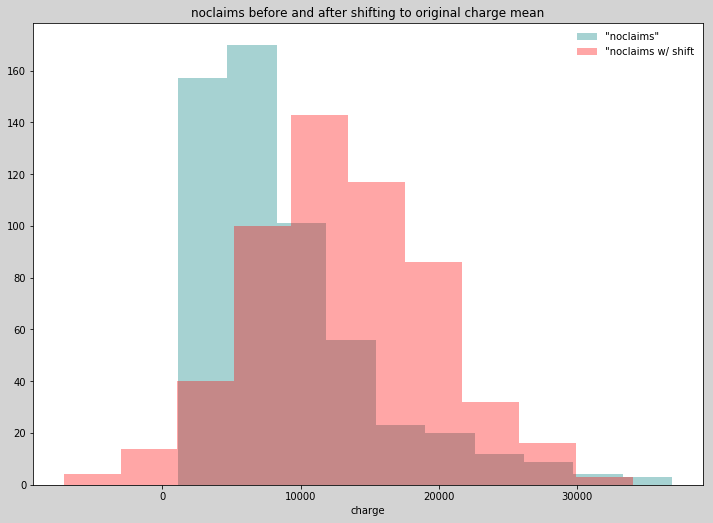

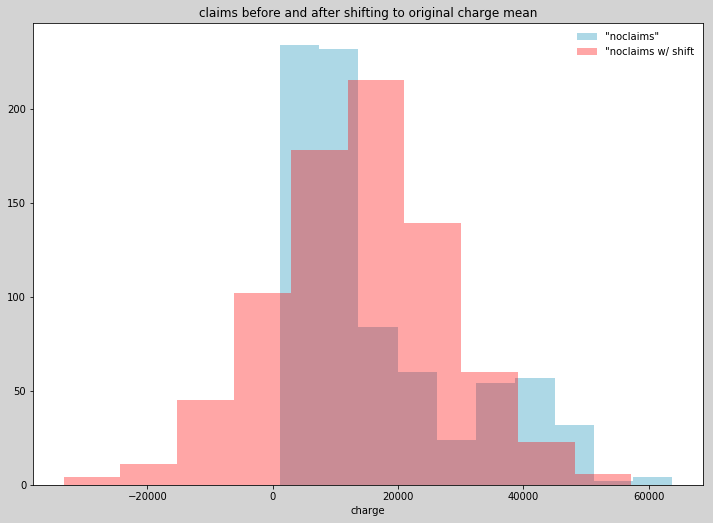

In [76]:
#manual SE no-claims charges sampling distribution
sdmnc_noclaims=np.mean(sampdistmeans_noclaims)
diff_noclaims = ((sampdistmeans_noclaims - sdmnc_noclaims)**2)
SE_bs_noclaims = np.sqrt(np.sum(diff_noclaims)/9999)
#manual se for claims charges sampling distribution
sdmc_claims=np.mean(sampdistmeans_claims)
diff_claims = (sampdistmeans_claims - sdmc_claims)**2
SE_bs_claims = np.sqrt(np.sum(diff_claims)/9999)
#print('manual SE:\nno-claims: %.3f, claims: %.3f\n' %(SE_bs_nc, SE_bs_c))

mean_charge = med_charges.charges.mean()
noclaim_shifted = ss.norm.rvs(loc=mean_charge, 
                              scale=noclaimsample.std(ddof=1),
                              size=len(noclaimsample))
# plot "noclaim_shifted"
plt.figure(figsize=(12,8.5), facecolor='lightgrey')
plt.hist(noclaimsample, label='"noclaims"', alpha=.35, color='teal'); plt.legend()
plt.hist(noclaim_shifted, label='"noclaims w/ shift', alpha=.35, color='r'); plt.legend(frameon=False)
plt.title('noclaims before and after shifting to original charge mean'); plt.xlabel('charge')
plt.show()

claim_shifted = ss.norm.rvs(loc=mean_charge, 
                            scale=claimsample.std(ddof=1), 
                            size=len(claimsample))
# plot "claim_shifted"
plt.figure(figsize=(12,8.5), facecolor='lightgrey')
plt.hist(claimsample, label='"noclaims"', color='lightblue'); plt.legend()
plt.hist(claim_shifted, label='"noclaims w/ shift', alpha=.35, color='r'); plt.legend(frameon=False)
plt.title('claims before and after shifting to original charge mean'); plt.xlabel('charge')
plt.show()

Below I'll Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured), 10,000 replicates as well as plot the distribution for the differences and mark the locations of the percentiles. For this, we'll State the null and alternative hypothesis and accept or reject Null. 

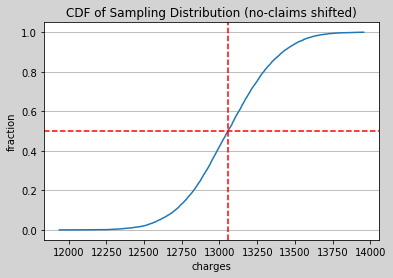

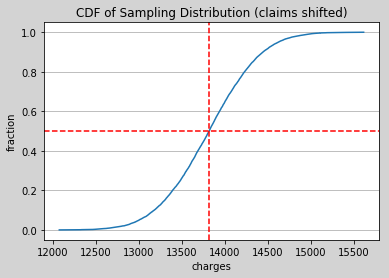

~ 95% CI RANGE ~
Lower limit of 95% CI: -352.5870978466238
Upper limit of 95% CI: 1864.2205123286294


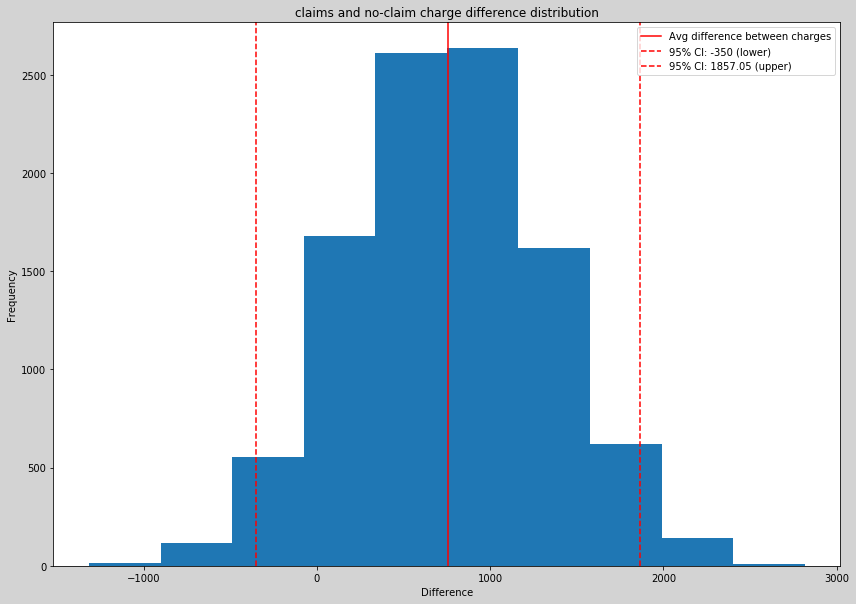

In [134]:
sampdist_noclaims_shft = [np.mean(np.random.choice(noclaim_shifted,
                                                   len(noclaim_shifted))) for _ in range(10000)]

sampdist_claims_shft = [np.mean(np.random.choice(claim_shifted, 
                                                 len(claim_shifted))) for _ in range(10000)]

# CDF of Sampling Distribution means, no-claims shifted
x_bs_noclaims = np.sort(sampdist_noclaims_shft)
n_bs_noclaims = x_bs_noclaims.size
cdf_bs_noclaims = np.arange(1, n_bs_noclaims+1) / n_bs_noclaims

plt.figure(facecolor='lightgrey')
plt.plot(x_bs_noclaims, cdf_bs_noclaims)
plt.axhline(0.5, c='r', ls='--')
plt.axvline(np.mean(sampdist_noclaims_shft), ls='--', c='r')
plt.title('CDF of Sampling Distribution (no-claims shifted)')
plt.xlabel('charges')
plt.ylabel('fraction')
plt.grid(axis='y')
plt.show()

# CDF of Sampling Distribution means, claims shifted
x_bs_claims = np.sort(sampdist_claims_shft)
n_bs_claims = x_bs_claims.size
cdf_bs_claims = np.arange(1, n_bs_claims+1) / n_bs_claims

plt.figure(facecolor='lightgrey')
plt.plot(x_bs_claims, cdf_bs_claims)
plt.axhline(0.5, c='r', ls='--')
plt.axvline(np.mean(sampdist_claims_shft), ls='--', c='r')
plt.title('CDF of Sampling Distribution (claims shifted)')
plt.xlabel('charges')
plt.ylabel('fraction')
plt.grid(axis='y')
plt.show()

differences = pd.Series(sampdist_claims_shft) - pd.Series(sampdist_noclaims_shft)
a = .05 / 2
conf_level = 1 - a
lower = differences.std() * ss.norm.ppf(a)
upper = differences.std() * ss.norm.ppf(conf_level)
print('~ 95% CI RANGE ~\nLower limit of 95% CI: {}\nUpper limit of 95% CI: {}\
'.format((differences.mean() + lower), (differences.mean() + upper)))

# Plot
plt.figure(figsize=(12,8.5), facecolor='lightgrey')
plt.hist(differences)
plt.axvline(differences.mean(), c='r', label='Avg difference between charges')
plt.axvline(differences.mean() + lower, c='r', ls='--', label='95% CI: -350 (lower)')
plt.axvline(differences.mean() + upper, c='r', ls='--', label='95% CI: 1857.05 (upper)')
plt.title('claims and no-claim charge difference distribution')
plt.ylabel('Frequency')
plt.xlabel('Difference')
plt.legend()
plt.tight_layout()

In [192]:
# Observed independant samples
noclaimsample = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
claimsample = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']

Shape for no-claims sample space: (10000, 555)... ("sample size", "n-observations")


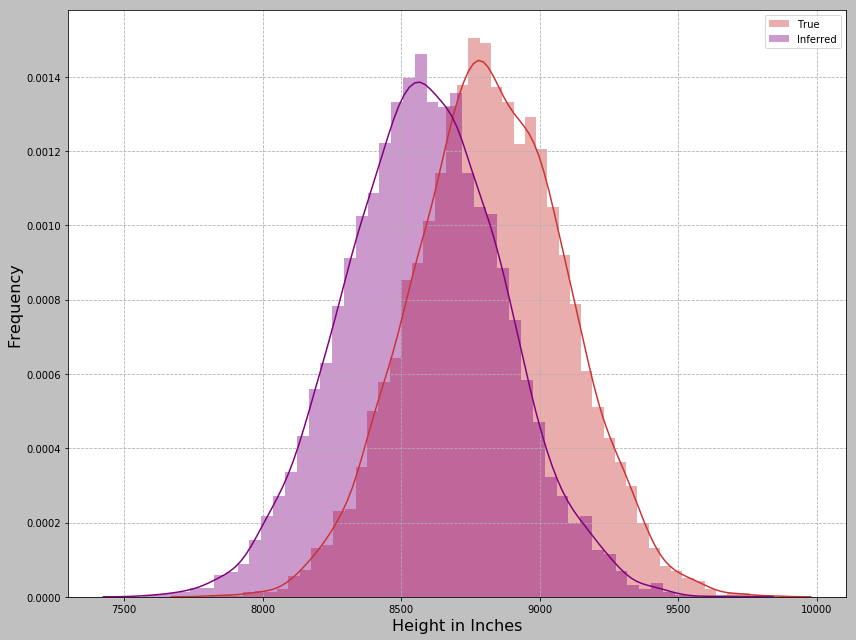

In [199]:
sns.set_palette("Reds")

sns.set_palette("Set1", 8, .75)

noClaims_mu = noclaimsample.mean()
noClaims_sigma = noclaimsample.std(ddof=1)

n_obs = len(noclaimsample)
sample_size = len(range(10000))
noClaims_samples = np.zeros((sample_size,n_obs))
print('Shape for no-claims sample space: {}\
... ("sample size", "n-observations")'.format(noClaims_samples.shape))

for i in range(noClaims_samples.shape[0]):
    for j in range(noClaims_samples.shape[1]):
        noClaims_samples[i,j] = noClaims_sigma * np.random.normal() + noClaims_mu
        
# Compare mean of all surveys with inferred distribution
fig, ax = plt.subplots(figsize=(12,9), facecolor='silver')

# Plot histogram for Sampling Distribution of means
sns.distplot(np.mean(noClaims_samples, axis=1), 
             kde=True, label='True')

# Calculate stats using single sample:
# aritrary individual trial/sample/survey #20 of n=10 height observations
singleSample_mean = np.mean(noClaims_samples[20])
singleSample_sd = np.sqrt(np.var(noClaims_samples[20])) # OR np.var(height_samples[20])**0.5

# the Square root of n observations from our individual sample
n_singleSample = height_samples[20].shape[0] # OR height_samples[20].shape[0]**0.5

# (SEM) Standard Error: sample SD / sqrt(sample mean)
SEM = singleSample_sd/(noClaims_samples[20].shape[0]) ** 0.5

# Infer distribution using single sample
# compute distribution based off SE and single sample mean to compare to Sampling Distribution
inferred_dist = [SEM * np.random.normal() + singleSample_mean for _ in range(10000)]

# Plot histogram of inferred distribution
sns.distplot(inferred_dist, kde=True, 
             label='Inferred', color='purple')
ax.set_xlabel("Height in Inches",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.grid(ls='--')
plt.legend()
plt.tight_layout()

In [ ]:
# Check out the distribution of the sample standard deviations
sampling_dist_sd = np.sqrt(np.var(noClaims_samples, axis=1))
# Histogram that shows the distribution of sample stdev
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(sampling_dist_sd, kde=False, 
             label='Sample SD Distribution')
ax.set_xlabel("charges",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.legend()

SEM = singleSample_sd/(noClaims_samples[20].shape[0]) ** 0.5
np.sqrt(np.var(SEM))
sns.distplot(sampling_dist_sd, kde=False, 
             label='Sample SD Distribution')
ax.set_xlabel("charges",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.legend()
plt.tight_layout()

[article](https://towardsdatascience.com/understanding-the-normal-distribution-with-python-e70bb855b027)

The 95% confidence Interval for the difference between means does span zero, therefore we accept null hypothesis on the assumption that there is a difference between means.

**Lets check our results with t-tests**

In [117]:
# Hypothesis test: Independant t-test
alpha = 0.05
t, df, critval, pval = independent_ttest(sampdist_noclaims_shft, sampdist_claims_shft, alpha)
print('t-statistic: %.3f\ndof: %.3f\ncritical value: %.3f\np-value: %.3f\n' %(t, df, critval, pval))

# Evaluate test w/ critical value
if np.abs(t) <= critval:
    print('~Hypothesis test w/ critical value\n  Fail to reject null, No difference between means.\n')
else:
    print('~Hypothesis test w/ critical value\n  Reject null; Difference between means.\n')
    

# Evaluate test w/ p-value
if pval > alpha:
    print('~p-value to test hypothesis\n  Fail to reject null (accept null hypothesis), means are equal.')
else:
    print('~p-value to test hypothesis\n  Reject null; Difference between means.')

t-statistic: -133.095
dof: 19998.000
critical value: 1.645
p-value: 0.000

~Hypothesis test w/ critical value
  Reject null; Difference between means.

~p-value to test hypothesis
  Reject null; Difference between means.


Above we performed bootstrapping to estimate the interval and where we reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions. **The partner of the confidence interval is the p-value.** The p-value and the confidence interval are linked through our choice of 𝛼. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our pre-specified 𝛼, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed. Remember how, previously, we used the t-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q2:__ Perform a bootstrapped hypothesis test at the 5% significance level (𝛼=0.05) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

**(initial works (below): SAMPLING DISTRIBUTION HISTOGRAMS)**

No CLAIMS

critical t: 1.960
Standard Error of mean: 273.216

95% Confidence Interval Range:
8283.818 - 9354.935


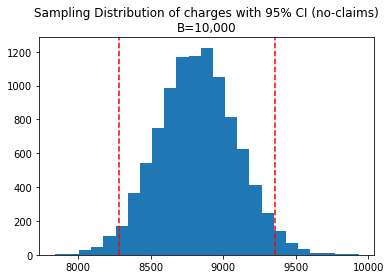

CLAIMS

critical t: 1.960
Standard Error of mean: 501.852

95% Confidence Interval Range:
15442.054 - 17409.517


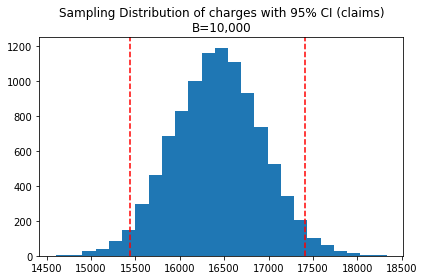

In [118]:
np.random.seed(2)
plt.hist(sampdistmeans_noclaims, bins=25)
mean_noclaims = np.mean(sampdistmeans_noclaims)
se_noclaims = np.std(sampdistmeans_noclaims, ddof=1)
t_noclaims = ss.t.ppf(.975, len(sampdistmeans_noclaims))
upper_noclaims = mean_noclaims + (t_noclaims*se_noclaims)
lower_noclaims = mean_noclaims - (t_noclaims*se_noclaims)
print('No CLAIMS\n\ncritical t: %.3f' %t_noclaims)
print('Standard Error of mean: %.3f\n' %se_noclaims)
print('95% Confidence Interval Range:\n{} - {}'.format(round(lower_noclaims,3), round(upper_noclaims,3)))

plt.title('Sampling Distribution of charges with 95% CI (no-claims)\nB=10,000')
plt.axvline(lower_noclaims,ls='--', c='r')
plt.axvline(upper_noclaims,ls='--', c='r')
plt.show()

plt.hist(sampdistmeans_claims, bins=25)
mean_claims = np.mean(sampdistmeans_claims)
se_claims = np.std(sampdistmeans_claims, ddof=1)
t_claims = ss.t.ppf(.975, len(sampdistmeans_claims))
upper_claims = mean_claims + (t_claims*se_claims)
lower_claims = mean_claims - (t_claims*se_claims)
print('CLAIMS\n\ncritical t: %.3f' %t_claims)
print('Standard Error of mean: %.3f\n' %se_claims)
print('95% Confidence Interval Range:\n{} - {}'.format(round(lower_claims,3), round(upper_claims,3)))

plt.title('Sampling Distribution of charges with 95% CI (claims)\nB=10,000')
plt.axvline(lower_claims,ls='--', c='r')
plt.axvline(upper_claims,ls='--', c='r')
plt.tight_layout()

**CDFS of SAMPLING DISTRIBUTIONS**

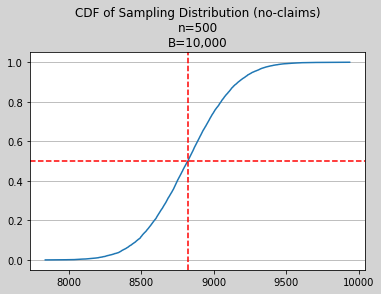

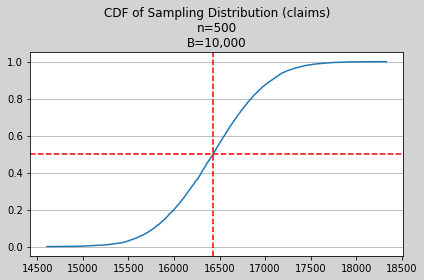

In [122]:
# CDF of Sampling Distribution means, no-claims
x_bs_noclaims = np.sort(sampdistmeans_noclaims)
n_bs_noclaims = x_bs_noclaims.size
cdf_bs_noclaims = np.arange(1, n_bs_noclaims+1) / n_bs_noclaims

plt.figure(facecolor='lightgrey')
plt.plot(x_bs_noclaims, cdf_bs_noclaims)
plt.axhline(0.5, c='r', ls='--')
plt.axvline(np.mean(sampdistmeans_noclaims), ls='--', c='r')
plt.title('CDF of Sampling Distribution (no-claims)\nn=500\nB=10,000')
plt.grid(axis='y')
plt.show()

# CDF of Sampling Distribution means, claims
x_bs_claims = np.sort(sampdistmeans_claims)
n_bs_claims = x_bs_claims.size
cdf_bs_claims = np.arange(1, n_bs_claims+1) / n_bs_claims

plt.figure(facecolor='lightgrey')
plt.plot(x_bs_claims, cdf_bs_claims)
plt.axhline(0.5, c='r', ls='--')
plt.axvline(np.mean(sampdistmeans_claims), ls='--', c='r')
plt.title('CDF of Sampling Distribution (claims)\nn=500\nB=10,000')
plt.grid(axis='y')
plt.tight_layout()

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

**DIFFERENCES**

~Sampling Distribution of difference between Means~
 - Mean (difference between charges): 7606.408
 - Standard Error(SE) (for difference between charges): 570.009
 - t: 1.960

~95% Confidence Interval Estimate for difference between average charges (w/ & w/o claims)
 - Range: [6489.075, 8723.741]
~95% Confidence Interval Estimate for difference between average charges (no t)
 - Range: [7036.398950744507, 8176.417590131653]


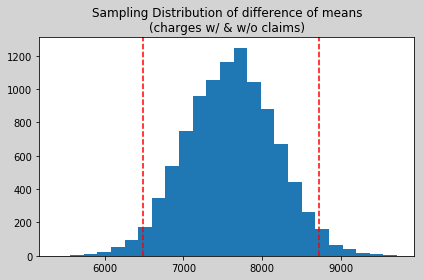

In [121]:
np.random.seed(2)

#diff between groups
sampdist_diffmeans = pd.Series(sampdistmeans_claims) - pd.Series(sampdistmeans_noclaims)
# stats
mean_diff = np.mean(sampdist_diffmeans)
se_diff = np.std(sampdist_diffmeans) #ddof=1
t_diff = ss.t.ppf(.975, len(sampdist_diffmeans))
print('~Sampling Distribution of difference between Means~')
print(' - Mean (difference between charges): %.3f' %mean_diff)
print(' - Standard Error(SE) (for difference between charges): %.3f' %se_diff)
print(' - t: %.3f\n' %t_diff)
# upper, lower w/ t 
upper_diff = round(mean_diff + (t_diff*se_diff), 3)
lower_diff = round(mean_diff - (t_diff*se_diff),3)
print('~95% Confidence Interval Estimate for difference between average charges (w/ & w/o claims)\n - Range: [{}, {}]'.format(lower_diff, upper_diff))
# w/o t, just mean + - SD
upper_diff_no_t = mean_diff + se_diff
lower_diff_no_t = mean_diff - se_diff
print('~95% Confidence Interval Estimate for difference between average charges (no t)\n - Range: [{}, {}]'.format(lower_diff_no_t, upper_diff_no_t))
# plot distribution of differences showing 95% CI
plt.figure(facecolor='lightgrey')
plt.hist(sampdist_diffmeans, bins=25)
plt.title('Sampling Distribution of difference of means\n(charges w/ & w/o claims)')
plt.axvline(lower_diff,ls='--', c='r')
plt.axvline(upper_diff,ls='--', c='r')
plt.tight_layout()

# scraps

np.random.seed(2)
sampdist_sd_noclaims = [np.std(np.random.choice(sampdistmeans_noclaims, 500), ddof=1) for _ in range(10000)]
#mean sd of sampling distributions of standard deviations
mean_sampdist_sd_noclaims = np.mean(sampdist_sd_noclaims)
print('average SD (no-claims): %.3f' %mean_sampdist_sd_noclaims)
#sd of sampling distribution of standard deviations
se_sampdist_sd_noclaims = np.std(sampdist_sd_noclaims)
print('Standard Error of SD (no-claims): %.3f' %se_sampdist_sd_noclaims)
#t
t_sd_diff = ss.t.ppf(.975, len(sampdist_sd_noclaims))
#upper lower for sampling distribution of sds no-claims
upper_sampdist_sd_noclaims = mean_sampdist_sd_noclaims + (t_sd_diff*se_sampdist_sd_noclaims)
lower_sampdist_sd_noclaims = mean_sampdist_sd_noclaims - (t_sd_diff*se_sampdist_sd_noclaims)
print('95% CI for sampling distribution of SDs (no-claims):\n{} - {}\n'.format(round(lower_sampdist_sd_noclaims,3), round(upper_sampdist_sd_noclaims,3)))

#plot sampling dist of SDs no-claims
plt.hist(sampdist_sd_noclaims, bins=25)
plt.title('Sampling Distribution of SDs (no-claims) with 95% CI\nB=10,000')
plt.axvline(lower_sampdist_sd_noclaims,ls='--', c='r')
plt.axvline(upper_sampdist_sd_noclaims,ls='--', c='r')
plt.show()


sampdist_sd_claims = [np.std(np.random.choice(sampdistmeans_claims, 500), ddof=1) for _ in range(10000)]
mean_sampdist_sd_claims = np.mean(sampdist_sd_claims)
print('average SD (w/ claims): %.3f\n' %mean_sampdist_sd_claims)
se_sampdist_sd_claims = np.std(sampdist_sd_claims)
print('Standard Error of SD (w/ claims): %.3f\n' %se_sampdist_sd_claims)
#upper lower for sampling distribution of sds w/ claims
upper_sampdist_sd_claims = mean_sampdist_sd_claims + (t_sd_diff*se_sampdist_sd_claims)
lower_sampdist_sd_claims = mean_sampdist_sd_claims - (t_sd_diff*se_sampdist_sd_claims)
print('95% CI for sampling distribution of SDs (w/ claims):\n{} - {}\n'.format(round(lower_sampdist_sd_claims,3), round(upper_sampdist_sd_claims,3)))

#plot sampling dist of SDs w/ claims
plt.hist(sampdist_sd_claims, bins=25)
plt.title('Sampling Distribution of SDs (w/ claims) with 95% CI\nB=10,000')
plt.axvline(lower_sampdist_sd_claims,ls='--', c='r')
plt.axvline(upper_sampdist_sd_claims,ls='--', c='r')
plt.tight_layout()

#SD differences
sampdist_diff_sds = pd.Series(sampdist_sd_claims) - pd.Series(sampdist_sd_noclaims)
plt.hist(sampdist_diff_sds, bins=25)
mean_sddiff = np.mean(sampdist_diff_sds)
se_sddiff = np.std(sampdist_diff_sds, ddof=2)
t_sddiff = ss.t.ppf(.975, len(sampdist_diff_sds))
upperdiff = round(mean_sddiff + (t_sddiff*se_sddiff), 3)
lowerdiff = round(mean_sddiff - (t_sddiff*se_sddiff),3)

print('~Sampling Distribution of difference between standard deviations~\n')
print(' - Mean (of difference between SDs): %.3f' %mean_sddiff)
print(' - Standard Error (of difference between SDs): %.3f' %se_sddiff)
print(' - t: %.3f\n' %t_sddiff)

print('~95% Confidence Interval Estimate (for difference between SDs/SEs of charges w/ and w/o claims)\n - Range: [{}, {}]'.format(lowerdiff, upperdiff))

plt.title('Sampling Distribution of difference of Standard Deviations\n(between charges w/ & w/o claims)\nB=10,000')
plt.axvline(lowerdiff,ls='--', c='r')
plt.axvline(upperdiff,ls='--', c='r')
plt.tight_layout()

n = len(noclaims) + len(claims)
dof = n - 2
t_vals, pdf_4_t = np.arange(-5, 5, 0.001)#np.linspace(-5, 5, 1000); ss.t.pdf(t_vals, dof)
plt.plot(t_vals, pdf_4_t)
plt.title('T-Distribution'); plt.xlabel('critical t-values'); plt.ylabel('Probability(p) of t'); plt.grid(axis='both'); plt.show()

#Define the distribution parameters, then Plot the t-distribution cdf
sample_space = np.arange(-5, 5, 0.001) # == np.linspace(-5, 5, 1000)
dof, cdf = len(sample_space) - 1; ss.t.cdf(sample_space, dof)
plt.plot(sample_space, cdf); plt.grid(axis='both'); plt.tight_layout()